In [33]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import os
from pathlib import Path

import torchvision
from torchvision import datasets

# import os
import numpy as np
import pandas as pd
from PIL import Image
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import ttach as tta

import albumentations as A
import albumentations.pytorch

import models
import config

In [34]:
start = time.time()

In [35]:
# setting seed
torch.manual_seed(0)
np.random.seed(0)

In [36]:
# setting device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
# HYPERPARAMS HERE

# params
lr = 3e-3
momentum = 0.9
weight_decay = 3e-3

# lr scheduler
step_size = 4 # after this many epochs we will mult our lr by gamma
gamma = 0.1 # lr multiplier every step_size epochs

# transforms
presize = 256
crop = 256

# batch size
batch_size = 32

# n_epochs
frozen = 2
unfrozen = 2

# tta
tta_crop = int(presize*0.9)

In [38]:
# transforms
train_transform = A.Compose([
        A.SmallestMaxSize(presize),
        A.RandomCrop(crop, crop),
        A.Normalize(),
        A.HorizontalFlip(),
        A.Rotate(limit=30),
        A.Cutout(),
        albumentations.pytorch.ToTensorV2()])

valid_transform = A.Compose([
        A.SmallestMaxSize(presize),
        A.CenterCrop(crop, crop),
        A.Normalize(),
        albumentations.pytorch.ToTensorV2()])

test_transform = A.Compose([
        A.SmallestMaxSize(presize),
        A.CenterCrop(crop, crop),
        A.Normalize(),
        albumentations.pytorch.ToTensorV2()])

In [39]:
# dataset class
class dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return (self.df.shape[0])

    def __getitem__(self, index):
        image = Image.open(self.df.fname[index]).convert('RGB')
        image = np.array(image)

        label = torch.tensor(self.df.label[index]).long()  

        if self.transform:
            augmentations = self.transform(image=image)
            image = augmentations['image']

        return image, label

In [40]:
# just to check if everything works we only use the sample of all data
frac = 0.2
# df = pd.read_csv(config.DF_PATH)
df = pd.read_csv(config.DF_PATH).sample(frac=frac) # <<<<---------------------------------------------
df.shape

(677, 16)

In [41]:
# create dfs
train_df = df[df.kfold.isin([0,1,2])].reset_index(drop=True)
valid_df = df[df.kfold==3].reset_index(drop=True)
test_df = df[df.kfold==4].reset_index(drop=True)

# create dataset
train_dataset = dataset(train_df, train_transform)
valid_dataset = dataset(valid_df, valid_transform)
test_dataset = dataset(test_df, test_transform)

# create loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


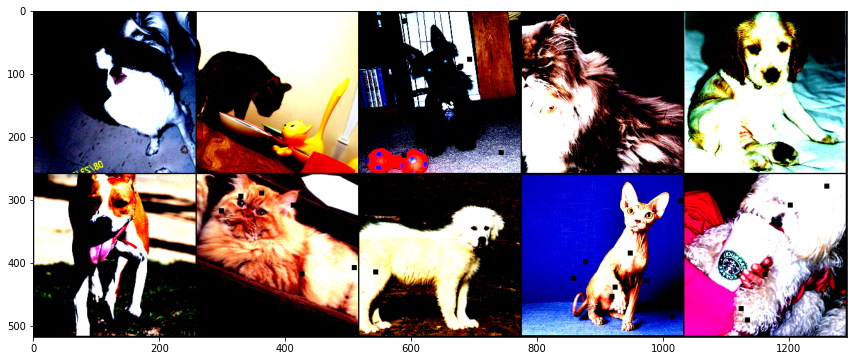

In [42]:
# displayig the data (looks this way because of normalization)
batch_tensor = next(iter(train_loader))[0][:10,...]
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)

# grid_img.shape
plt.figure(figsize=(16,6))
plt.imshow(grid_img.permute(1, 2, 0));

In [43]:
# just a check if all is good with the shapes of the loaders
print(f'dataloader test: {next(iter(train_loader))[0].shape}, {next(iter(valid_loader))[0].shape}')

dataloader test: torch.Size([32, 3, 256, 256]), torch.Size([32, 3, 256, 256])


In [44]:
model = models.resnet18(2).to(device) # good
# model = models.vgg().to(device) # good
# model = models.alexnet().to(device) # bad

# loss
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [45]:
def train_model(n_epochs=1,
                model=model,
                train_loader=train_loader,
                valid_loader=valid_loader,
                criterion=criterion,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler):
    
    total_time = time.time()
    print(f'================')
    print(f'started training...')
    
    for epoch in range(n_epochs):
        
        model.train()

        t0 = time.time()

        correct_on_epoch = 0 # train acc
        total_num_images = 0 # train acc
        epoch_loss = 0

        for batch, (images, labels) in enumerate(train_loader):

            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            total_num_images += images.size(0) # train acc

            optimizer.zero_grad()
            outputs = model(images)
            _, preds = torch.max(outputs, 1) # train acc

            loss = criterion(outputs, labels)
            epoch_loss += loss

            correct_on_epoch += (preds==labels).sum().item() # train acc

            loss.backward()
            optimizer.step()
        
        train_epoch_acc = round((correct_on_epoch/total_num_images), 4) # train acc
        train_avg_epoch_loss = round(float(epoch_loss/len(train_loader)), 4)

        valid_avg_epoch_loss, valid_epoch_accuracy = test_model(model, valid_loader)
        
        epoch_time = round(time.time() - t0)
        
        lr_scheduler.step()
        
        print(f'epoch: [{epoch+1}/{n_epochs}] | train loss: {train_avg_epoch_loss} | train acc: {train_epoch_acc} | valid loss: {valid_avg_epoch_loss} | valid acc: {valid_epoch_accuracy} | time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s')
    
    return model

In [46]:
def test_model(model, test_loader):
    
    model.eval()
    
    correct_on_epoch = 0
    total_num_images = 0
    epoch_loss = 0

    all_batch_acc = []
    
    with torch.no_grad():
        
        for batch, (images, labels) in enumerate(test_loader):
            
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            total_num_images += images.size(0)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)
            epoch_loss += loss

            correct_on_epoch += (preds==labels).sum().item()
    
            # test_batch_accuracy = accuracy_score(labels, preds) #temp
            # all_batch_acc.append(test_batch_accuracy) #temp

    test_epoch_accuracy = round((correct_on_epoch/total_num_images), 4)
    test_avg_epoch_loss = round(float(epoch_loss/len(test_loader)), 4)

    # total_acc = round(np.mean(all_batch_acc), 4) #temp
    
    # print(f'total acc with acc_score: {total_acc}') #temp
    return test_avg_epoch_loss, test_epoch_accuracy

In [47]:
# unfreeze all the params for training
def unfreeze(model=model):
    for param in model.parameters():
        param.requires_grad = True
    return model

In [48]:
%%time

train_model(frozen)
unfreeze()
train_model(unfrozen)
print('Training done.')

started training...
epoch: [1/2] | train loss: 0.4657 | train acc: 0.7616 | valid loss: 0.1717 | valid acc: 0.965 | time: 0m 40s
epoch: [2/2] | train loss: 0.143 | train acc: 0.9757 | valid loss: 0.0744 | valid acc: 0.972 | time: 0m 42s
started training...
epoch: [1/2] | train loss: 0.109 | train acc: 0.9562 | valid loss: 0.0595 | valid acc: 0.979 | time: 1m 28s
epoch: [2/2] | train loss: 0.0528 | train acc: 0.983 | valid loss: 0.0152 | valid acc: 1.0 | time: 1m 26s

Wall time: 4min 15s


In [49]:
checkpoint = {'model': model,
              'state_dict': model.state_dict()}

torch.save(checkpoint, config.MODEL_OUTPUT)

In [50]:
%%time
# testing with train data
_, train_acc = test_model(model, train_loader)
print(f'test set acc: {train_acc}')

test set acc: 0.9927
Wall time: 30 s


In [51]:
%%time
# testing with test data
_, test_acc = test_model(model, test_loader)
print(f'test set acc: {test_acc}')

KeyboardInterrupt: 

In [29]:
%%time
# tta with test data
tta_crop = int(presize*0.9)
tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.five_crop_transform(tta_crop, tta_crop))

tta_transforms = A.Compose([
    A.SmallestMaxSize(presize),
    A.Normalize(),
    albumentations.pytorch.ToTensorV2()
])

tta_dataset = dataset(valid_df, transform=tta_transforms)
tta_loader = DataLoader(tta_dataset, batch_size=1, shuffle=False) # num_workers=0 on cpu

_, tta_acc = test_model(tta_model, tta_loader)

print(f'TTA acc: {tta_acc}')

KeyboardInterrupt: 

In [22]:
total_time = time.time() - start
print(f'Total time: {total_time//60:.0f}m {total_time%60:.0f}s')

Total time: 5m 55s
